In [ ]:
# This file is a standard train test procedure.

In [1]:
import numpy as np
import os
import pickle

import torch
from torch.utils.data import DataLoader

from models import CovidCNNModel, CovidDataset, train, plotTrainingProcess, testPerformance
import models

%load_ext autoreload
%autoreload 1
%aimport models


In [2]:
# Use GPU to train and infer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Read data

In [3]:
# Set dataset path
dataset_path = r"examples/single/"

In [4]:
# with open(os.path.join(dataset_path, "cropped_30720.pkl"), "rb") as f:
#     data = pickle.load(f)
#     label = np.asarray(data["label"])
#     np.save("label.npy", label)

In [5]:
mfccs = np.load(os.path.join(dataset_path, "mfcc39_fixlength_30720_nmfcc_39_framelength_2048_hoplength_1024.npy"))
filepath = "label.npy"
label = np.load(os.path.join(dataset_path, filepath))

In [6]:
X = mfccs
y = np.asarray(label)

Configuration

In [7]:
record_freq = 1
epoch_num = 20
batch_size = 50

Prepare dataset

- Reshape inputs into (N, C, H, W)

In [8]:
X = X[:, None, :, :]
print(X.shape)

(328, 1, 39, 31)


In [9]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1 - train_ratio, stratify=y, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=test_ratio / (test_ratio + val_ratio), stratify=y_val, random_state=7)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(262, 1, 39, 31)
(262,)
(33, 1, 39, 31)
(33,)
(33, 1, 39, 31)
(33,)


In [10]:
n_class = np.unique(y).shape[0]

trainset = CovidDataset(X_train, y_train, n_class)
trainloader = DataLoader(trainset, batch_size, shuffle = True, num_workers = 0)

valset = CovidDataset(X_val, y_val, n_class)
valloader = DataLoader(valset, batch_size, shuffle = True, num_workers = 0)

testset = CovidDataset(X_test, y_test, n_class)
testloader = DataLoader(testset, batch_size, shuffle = True, num_workers = 0)

Training

In [11]:
model = models.CovidCNNModel(trainset)
model.to(device)

CovidCNNModel(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=7072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [12]:
train_accuracies, train_losses, val_accuracies, val_losses, out_dir = train(
    model = model, 
    trainloader = trainloader, 
    valloader = valloader, 
    epoch_num = epoch_num,
    record_freq = record_freq,
    out_dir = dataset_path)

[2023-05-30 10:35:06] [epoch:1, batch:  1] training loss: 0.6926, training accuracy: 0.520, validation loss: 0.6704, validation accuracy: 0.515, time used:  4.0 s, total time used:  4.0 s.
[2023-05-30 10:35:06] [epoch:1, batch:  2] training loss: 0.6713, training accuracy: 0.520, validation loss: 0.6480, validation accuracy: 0.667, time used:  4.0 s, total time used:  4.0 s.
[2023-05-30 10:35:06] [epoch:1, batch:  3] training loss: 0.6382, training accuracy: 0.640, validation loss: 0.6254, validation accuracy: 0.879, time used:  4.0 s, total time used:  4.0 s.
[2023-05-30 10:35:06] [epoch:1, batch:  4] training loss: 0.6338, training accuracy: 0.640, validation loss: 0.6041, validation accuracy: 0.909, time used:  4.1 s, total time used:  4.1 s.
[2023-05-30 10:35:06] [epoch:1, batch:  5] training loss: 0.6334, training accuracy: 0.700, validation loss: 0.5855, validation accuracy: 0.939, time used:  4.1 s, total time used:  4.1 s.
[2023-05-30 10:35:06] [epoch:1, batch:  6] training los

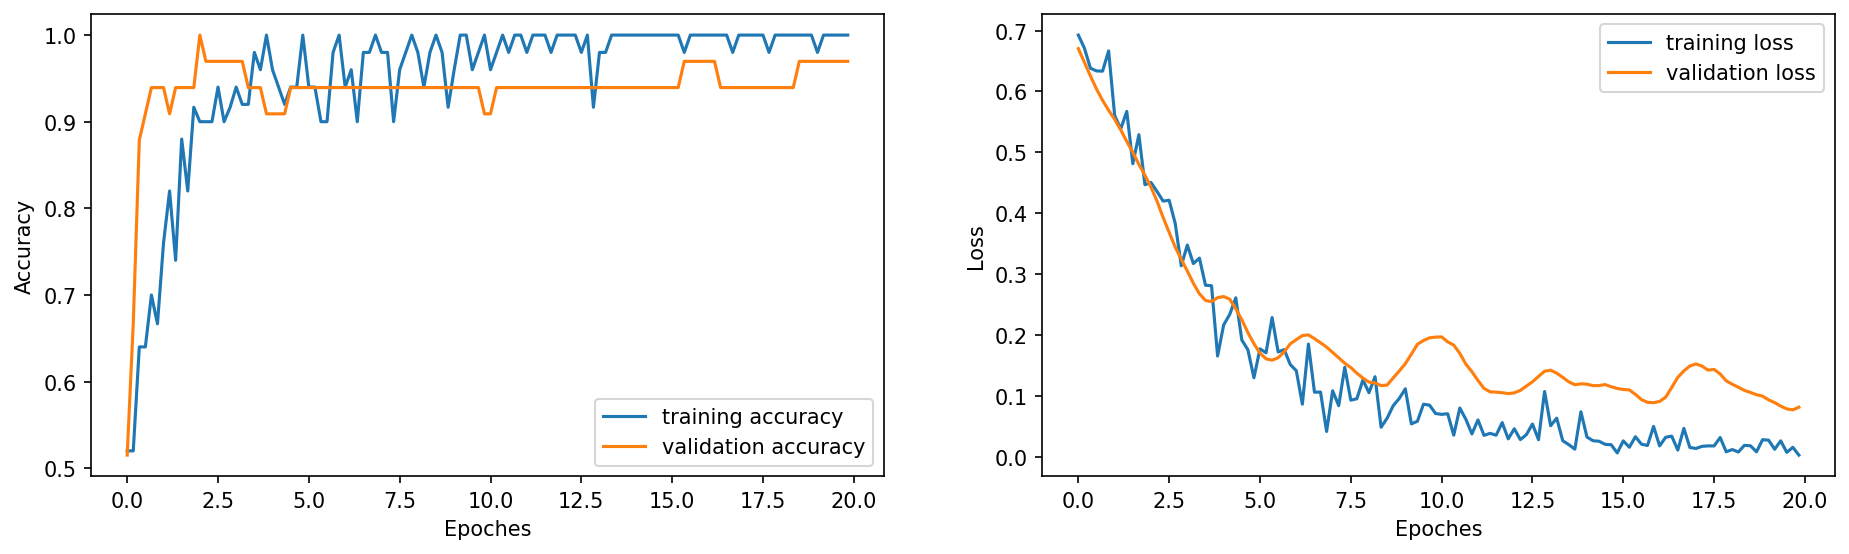

In [13]:
plotTrainingProcess(
    record_freq, 
    trainloader, 
    train_accuracies, 
    train_losses, 
    val_accuracies, 
    val_losses,
    out_dir
    )

[2023-05-30 10:35:22] [test performance] Test accuracy: 0.939, Test loss: 0.4629
[2023-05-30 10:35:22] [class: 0] AUC: 0.9963235294117647
[2023-05-30 10:35:22] [class: 1] AUC: 0.9963235294117647


(0.9393939393939394, 0.4629335403442383, array([0.99632353, 0.99632353]))

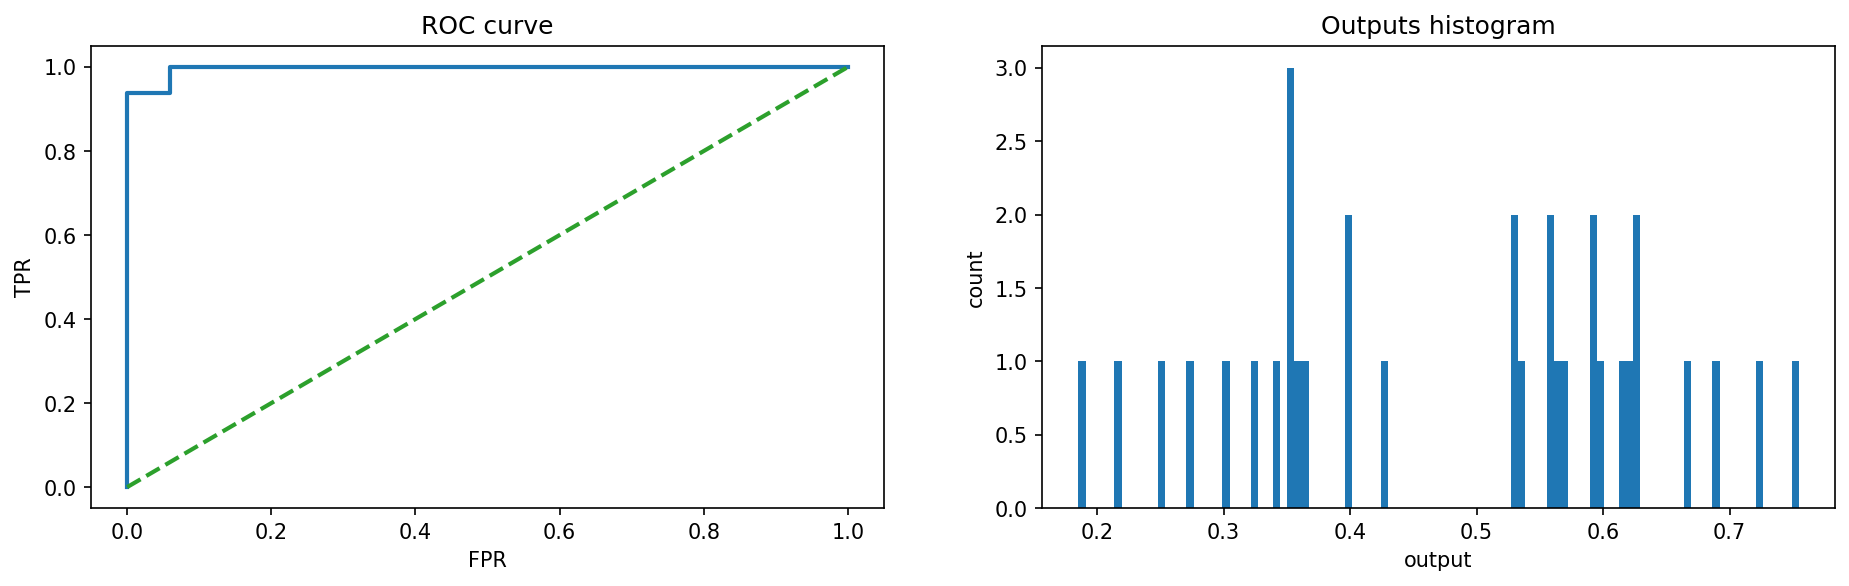

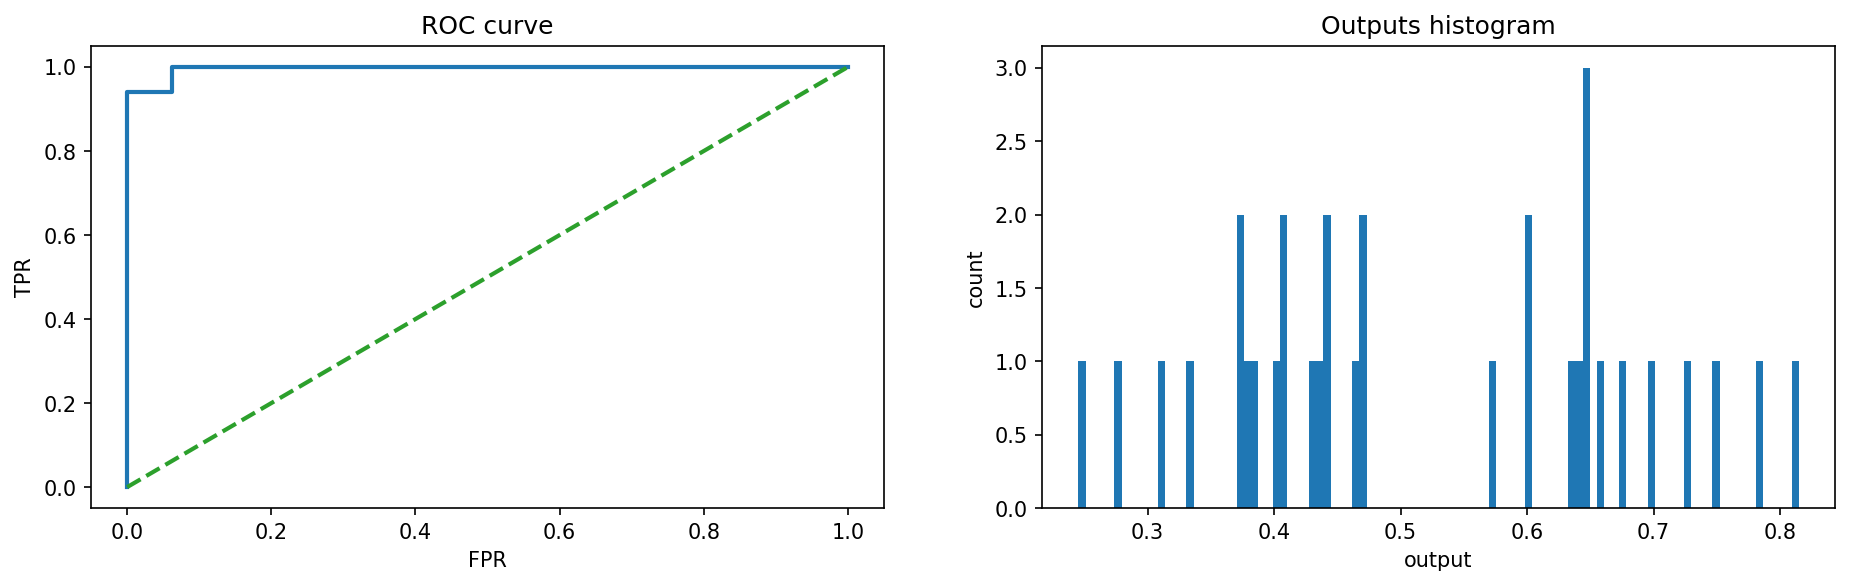

In [14]:
model.load_state_dict(torch.load(os.path.join(out_dir, "best_model.pth")))

testPerformance(model, testloader, out_dir = out_dir)

Cross Validation

In [15]:
# Prepare the data to be (N, H, W)
X = X.squeeze()
X.shape

(328, 39, 31)

In [16]:
from models import cross_validation_test

cross_validation_test(
    module = CovidCNNModel,
    X = X,
    y = y,
    batch_size = batch_size,
    epoch_num = epoch_num,
    out_dir = dataset_path
)

cuda:0
[2023-05-30 10:35:36] [epoch:1, batch:  1] training loss: 0.6691, training accuracy: 0.580, validation loss: 0.6815, validation accuracy: 0.485, time used:  0.2 s, total time used:  0.2 s.
[2023-05-30 10:35:36] [epoch:1, batch:  2] training loss: 0.7004, training accuracy: 0.460, validation loss: 0.6316, validation accuracy: 0.515, time used:  0.3 s, total time used:  0.3 s.
[2023-05-30 10:35:36] [epoch:1, batch:  3] training loss: 0.6685, training accuracy: 0.680, validation loss: 0.5890, validation accuracy: 0.939, time used:  0.3 s, total time used:  0.3 s.
[2023-05-30 10:35:36] [epoch:1, batch:  4] training loss: 0.5913, training accuracy: 0.780, validation loss: 0.5590, validation accuracy: 1.000, time used:  0.4 s, total time used:  0.4 s.
[2023-05-30 10:35:36] [epoch:1, batch:  5] training loss: 0.5868, training accuracy: 0.800, validation loss: 0.5316, validation accuracy: 0.970, time used:  0.4 s, total time used:  0.4 s.
[2023-05-30 10:35:36] [epoch:1, batch:  6] train

(0.9212121212121213, 0.35984054912220353, 0.9838235294117647)

In [114]:
from models import n_times_cross_validation_test

n_times_cross_validation_test(
    n_times = 5,
    module = CovidCNNModel,
    X = X,
    y = y,
    batch_size = batch_size,
    epoch_num = epoch_num,
    out_dir = dataset_path
)

time 0
cuda:0
[2023-03-29 11:49:15] [epoch:1, batch:  1] training loss: 0.6505, training accuracy: 0.700, validation loss: 0.6776, validation accuracy: 0.500, time used:  1.0 s, total time used:  1.0 s.
[2023-03-29 11:49:15] [epoch:1, batch:  2] training loss: 0.7639, training accuracy: 0.400, validation loss: 0.6656, validation accuracy: 0.600, time used:  1.0 s, total time used:  1.0 s.
[2023-03-29 11:49:15] [epoch:1, batch:  3] training loss: 0.6901, training accuracy: 0.600, validation loss: 0.6559, validation accuracy: 0.600, time used:  1.0 s, total time used:  1.0 s.
[2023-03-29 11:49:15] [epoch:1, batch:  4] training loss: 0.6787, training accuracy: 0.600, validation loss: 0.6503, validation accuracy: 0.600, time used:  1.1 s, total time used:  1.1 s.
[2023-03-29 11:49:15] [epoch:1, batch:  5] training loss: 0.6398, training accuracy: 0.500, validation loss: 0.6437, validation accuracy: 0.700, time used:  1.1 s, total time used:  1.1 s.
[2023-03-29 11:49:15] [epoch:1, batch:  6